## Imports and functions

In [1]:
# imports
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import os
import itertools
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

In [2]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

# load data 

In [6]:
# data
tesla_data = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/tesla_ticker/data/tesla_stock_data.csv')

In [7]:
tesla_data

,Date,Year,Open,High,Low,Close,Volume,Adj Close
0,2020-01-02,2020,28.299999,28.713333,28.114000,28.684000,142981500,28.684000
1,2020-01-03,2020,29.366667,30.266666,29.128000,29.534000,266677500,29.534000
2,2020-01-06,2020,29.364668,30.104000,29.333332,30.102667,151995000,30.102667
3,2020-01-07,2020,30.760000,31.441999,30.224001,31.270666,268231500,31.270666
4,2020-01-08,2020,31.580000,33.232666,31.215334,32.809334,467164500,32.809334
...,...,...,...,...,...,...,...,...
991,2023-12-22,2023,256.760010,258.220001,251.369995,252.539993,93249800,252.539993
992,2023-12-26,2023,254.490005,257.970001,252.910004,256.609985,86892400,256.609985
993,2023-12-27,2023,258.350006,263.339996,257.519989,261.440002,106494400,261.440002
994,2023-12-28,2023,263.660004,265.130005,252.710007,253.179993,113619900,253.179993


In [8]:
tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       996 non-null    object 
 1   Year       996 non-null    int64  
 2   Open       996 non-null    float64
 3   High       996 non-null    float64
 4   Low        996 non-null    float64
 5   Close      996 non-null    float64
 6   Volume     996 non-null    int64  
 7   Adj Close  996 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 62.4+ KB


## Year

In [9]:
tesla_data['Year'] = tesla_data['Year'].astype(object)

In [10]:
tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       996 non-null    object 
 1   Year       996 non-null    object 
 2   Open       996 non-null    float64
 3   High       996 non-null    float64
 4   Low        996 non-null    float64
 5   Close      996 non-null    float64
 6   Volume     996 non-null    int64  
 7   Adj Close  996 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 62.4+ KB


In [11]:
tesla_data['Year'].unique()

array([2020, 2021, 2022, 2023], dtype=object)

## Open

In [12]:
tesla_data['Open'].min()

24.979999542236328

In [13]:
tesla_data['Open'].max()

411.4700012207031

## High

In [14]:
tesla_data['High'].min()

26.99066734313965

In [15]:
tesla_data['High'].max()

414.4966735839844

## Low

In [16]:
tesla_data['Low'].min()

23.367332458496094

In [17]:
tesla_data['Low'].max()

405.6666564941406

## Volume

In [18]:
tesla_data['Volume'].min()

29401800

In [19]:
tesla_data['Volume'].max()

914082000

## Adj Close

In [20]:
tesla_data['Adj Close'].min()

24.08133316040039

In [21]:
tesla_data['Adj Close'].max()

409.9700012207031

In [33]:
tesla_adj_close = tesla_data.drop(columns=['Year', 'Open', 'High', 'Low', 'Close', 'Volume'])
tesla_adj_close

,Date,Adj Close
0,2020-01-02,28.684000
1,2020-01-03,29.534000
2,2020-01-06,30.102667
3,2020-01-07,31.270666
4,2020-01-08,32.809334
...,...,...
991,2023-12-22,252.539993
992,2023-12-26,256.609985
993,2023-12-27,261.440002
994,2023-12-28,253.179993


In [34]:
tesla_adj_close['Date'] = pd.to_datetime(tesla_adj_close['Date'])
tesla_adj_close

,Date,Adj Close
0,2020-01-02,28.684000
1,2020-01-03,29.534000
2,2020-01-06,30.102667
3,2020-01-07,31.270666
4,2020-01-08,32.809334
...,...,...
991,2023-12-22,252.539993
992,2023-12-26,256.609985
993,2023-12-27,261.440002
994,2023-12-28,253.179993


In [37]:
tesla_adj_close = tesla_adj_close.set_index('Date')
tesla_adj_close.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=996, freq=None)

In [39]:
tesla_adj_close = tesla_adj_close.resample('B').asfreq()

In [40]:
tesla_adj_close.isna().sum()

Adj Close    46
dtype: int64

In [42]:
tesla_adj_close = tesla_adj_close.fillna(method = 'ffill')

In [43]:
tesla_adj_close.isna().sum()

Adj Close    0
dtype: int64

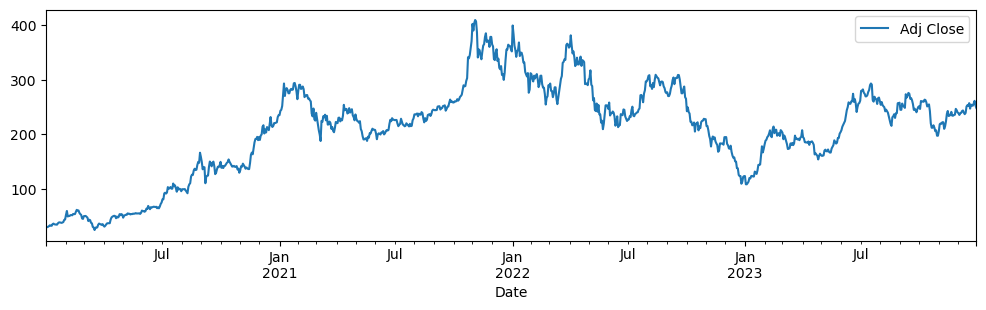

In [44]:
tesla_adj_close.plot();